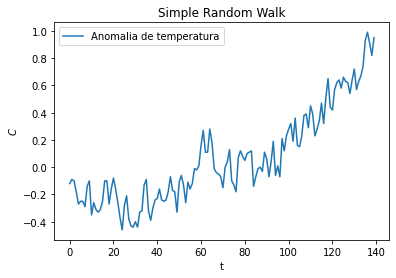

In [1]:
#Primero importamos las bibliotecas que utilizaremos en este documento

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import scipy.signal as ss

#Ahora leemos el archivo con terminación csv para empezar a trabajar

datos= pd.read_csv('Datos para investigacion.csv')
anomalia = datos['Value']

#Esta parte es sólo para visualizar la información

plt.title("Simple Random Walk")
plt.ylabel("$C$")
plt.xlabel("t")
plt.plot(anomalia, label = 'Anomalia de temperatura');
plt.legend();

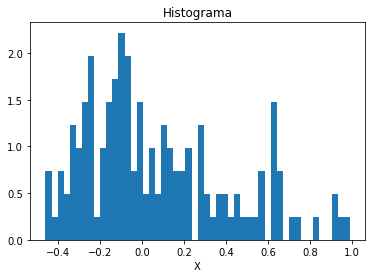

In [2]:
#Aquí generamos un histograma que no servirá para definir ciertas funciones en los siguientes apartados

plt.title("Histograma")
plt.xlabel('X')
h, x, foo = plt.hist(anomalia, bins = 50, density = True);

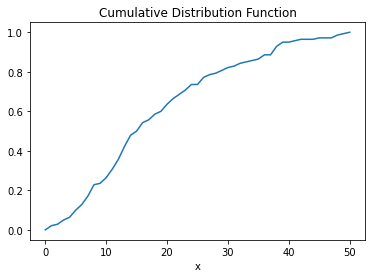

In [3]:
#En este apartado generamos una función acumulativa que nos dará la posibilidad de obtener valors entre 0 y 1

def CDF(x, f):
    n = len(f)
    F =np.zeros(n+1)
    for i in range(n):
        F[i+1] = F[i] + f[i]*(x[i+1]-x[i])
    return F

H = CDF(x, h)

plt.title("Cumulative Distribution Function")
plt.xlabel('x')
plt.plot(H);

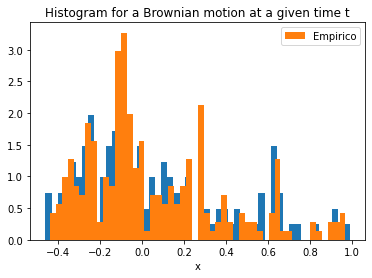

In [4]:
#Aquí definimos una función que nos servirá para poder extrapolar valores dentro de nuestra información
#y así generar un proceso estocástico

def Empirico(F, x): 
    t = np.random.ranf() 
    y = F < t
    k = np.sum(y)
    m = (F[k] - F[k-1])/(x[k] - x[k-1]) 
    x_0 = (t - F[k])/m + x[k]
    return x_0

N = 250
Y =np.zeros(N)
t = np.linspace(0,250, N)
for i in range(N):
    x_0 = Empirico(H, x)
    Y[i] = x_0

plt.title('Histogram for a Brownian motion at a given time t')
plt.xlabel('x')
plt.hist(anomalia, bins = 50 , density = True)
plt.hist(Y, bins = 50, density = True, label = 'Empirico');
plt.legend();

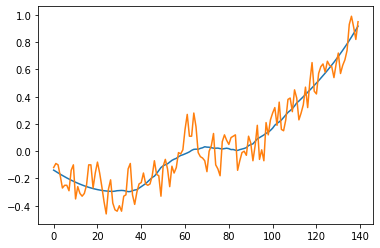

In [5]:
#Suavizamos la información que a través del filtro Savitzky-Golay y se compara con la información original

filtrado = ss.savgol_filter(anomalia, 55, 3)
plt.plot(filtrado);
plt.plot(anomalia);
N_f = len(filtrado)
x_f = np.arange(0, 140)

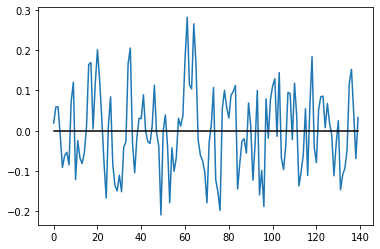

In [6]:
#En este apartado se toman los datos originales y se les resta los datos que se han filtrado para que oscilen alrededor
#del eje horizontal

Datos_menos_media = []
for i in range(len(anomalia)):
    Datos_menos_media.append(anomalia[i] - filtrado[i])
plt.plot(Datos_menos_media);
t =np.zeros(140)
plt.plot(t, color = 'k');

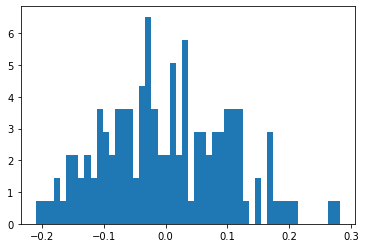

In [7]:
#Nuevamente realizamos un histograma con la información nueva

h, x, foo = plt.hist(Datos_menos_media, bins = 50, density = True);

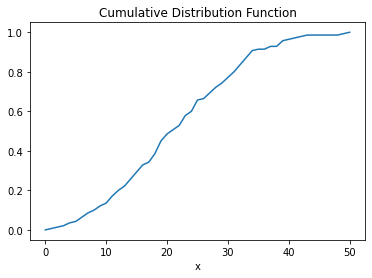

In [8]:
#Y su respectiva función acumulativa

H = CDF(x, h)

plt.title("Cumulative Distribution Function")
plt.xlabel('x')
plt.plot(H);

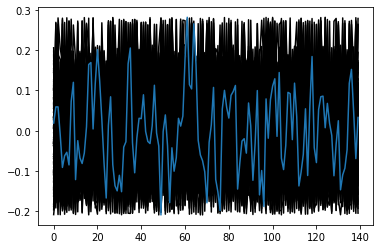

In [9]:
#Aquí es que generamos el ruido dónde puede oscilar nuestra información
#El número de realizaciones está definido por T, pero usted puede cambiar el valor para que observe el comportamiento

T = 100
ruido = np.zeros(N_f)
t = np.linspace(0,139, 140)
for z in range(T):
    for i in range(N_f):
        x_0 = Empirico(H, x)
        ruido[i] = x_0
    plt.plot(t, ruido, color = 'k')
plt.plot(anomalia-filtrado);

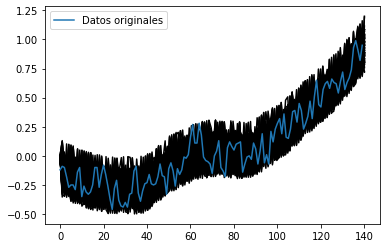

In [10]:
#Una vez que tenemos el ruido, podemos definir otra variable que nos represente al movimiento que tiene el ruido alrededor
#de nuestro filtro

steps = 140
t = np.linspace(0, 140, steps)
dt = t[1]-t[2]
dx = np.zeros(steps)
for z in range(T):
    for i in range(1, steps):
        x_0 = Empirico(H, x)
        ruido[i] = x_0
        dx[i] = filtrado[i] + ruido[i]

    plt.plot(t, dx, color = 'k')
plt.plot(anomalia, label = 'Datos originales');
plt.legend();

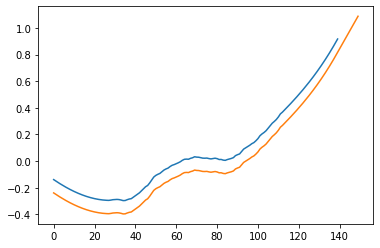

In [11]:
#En esta sección es que podemos empezar a realiza la predicción al futuro definida por la variable "a", puede modificarlo para 
#Verificar cambios

m = (filtrado[len(filtrado)-1] - filtrado[len(filtrado)-2])/(t[len(t)-1] - t[len(t)-2])

a = 10
y = np.zeros(a)
y[0] = filtrado[-1] + m
for i in range(1, a):
    y[i] = m + y[i-1]

filtro_extendido = np.concatenate((filtrado,y))
plt.plot(filtrado)
plt.plot(filtro_extendido-0.1); #El -0.1 es sólo para poder visualizar mejor la gráfica, pues una queda oculta

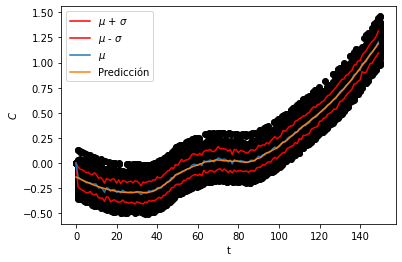

In [12]:
#En este apartado realizamos cálculos estadísticos con la información obtenida de los procesos estocásticos,
#Obteniendo la media y la desviación estándar de cada una de las realizaciones en los puntos específicos del tiempo
steps = 140 + a
t = np.linspace(0, 140 + a, steps)
dx = np.zeros(steps)
ruido = np.zeros(steps)
valores = np.zeros((T, steps))
valores_organizados = np.zeros((steps, T))
medias = np.zeros(steps)
varianzas = np.zeros(steps)

for z in range(T):
    for i in range(1, steps):
        x_0 = Empirico(H, x)
        ruido[i] = x_0
        dx[i] = filtro_extendido[i] + ruido[i]
        valores[z][i] = dx[i]
    plt.plot(t, dx, linestyle = 'None', marker = 'o', color = 'k')

for r in range(steps):
    for z in range(T):
        valores_organizados[r][z] = valores[z][r]
for i in range(steps):
    medias[i] = np.sum(valores_organizados[i])/T

for i in range(steps):
    varianzas[i] = np.sum(((medias[i] - valores_organizados[i])**2)/T)

desviacion_estandar = np.sqrt(varianzas)

plt.ylabel("$C$")
plt.xlabel("t")
plt.plot(medias + desviacion_estandar, label = '$\mu$ + $\sigma$', color = 'r')
plt.plot(medias - desviacion_estandar, label = '$\mu$ - $\sigma$', color = 'r')
plt.plot(medias, label = '$\mu$')
plt.plot(filtro_extendido, label = 'Predicción');
plt.legend();